In [1]:
import ast
import pathlib
import sys

import numpy as np
import pandas as pd
import toml
import torch
from sklearn import preprocessing

sys.path.append("../..")


import matplotlib.pyplot as plt
import seaborn as sns
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    output_stats,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

sys.path.append("../../..")
import argparse

In [2]:
# set up the parser
parser = argparse.ArgumentParser(description="Train MLP model")

# add arguments to parser
parser.add_argument(
    "--CELL_TYPE",
    type=str,
    default="all",
    help="Cell type to train model on. Default is all",
)

parser.add_argument(
    "--MODEL_NAME",
    type=str,
    default="MLP",
    help="Model name to train. Default is MLP",
)

parser.add_argument(
    "--SHUFFLE",
    type=str,
    default="False",
    help="Shuffle data before training. Default is False",
)

# parse the arguments
args = parser.parse_args()

CELL_TYPE = args.CELL_TYPE
MODEL_NAME = args.MODEL_NAME
SHUFFLE = args.SHUFFLE
SHUFFLE = ast.literal_eval(SHUFFLE)
print(CELL_TYPE, MODEL_NAME, SHUFFLE)

In [4]:
ml_configs_file = pathlib.Path("../../MLP_utils/multi_class_config.toml").resolve(
    strict=True
)
ml_configs = toml.load(ml_configs_file)
params = Parameters()
mlp_params = parameter_set(params, ml_configs)

# overwrite params via command line arguments from papermill
mlp_params.CELL_TYPE = CELL_TYPE
mlp_params.MODEL_NAME = MODEL_NAME

mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.SHUFFLE = SHUFFLE

# load in the class weights
class_weights_file_path = pathlib.Path(
    f"../../0.hyperparameter_optimization/class_weights/{CELL_TYPE}/multi_class/class_weights.txt"
).resolve(strict=True)
# read the class weights into a list for use in the loss function as a list
class_weights = []
with open(class_weights_file_path, "r") as f:
    for line in f:
        class_weights.append(float(line.strip()))
# check the class weights are correct
print(class_weights)

[0.9473684210526316, 0.5, 0.5526315789473684]


In [5]:
# Import Data
# set data file path under pathlib path for multi-system use

file_path = pathlib.Path(
    f"../../../data/{mlp_params.CELL_TYPE}_preprocessed_sc_norm.parquet"
).resolve(strict=True)

df1 = pd.read_parquet(file_path)

In [6]:
# get paths for toml files
ground_truth_file_path = pathlib.Path(f"../../MLP_utils/ground_truth.toml").resolve(
    strict=True
)
treatment_splits_file_path = pathlib.Path(f"../../MLP_utils/splits.toml").resolve(
    strict=True
)
# read toml files
ground_truth = toml.load(ground_truth_file_path)
treatment_splits = toml.load(treatment_splits_file_path)

In [7]:
# get information from toml files
apoptosis_groups_list = ground_truth["Apoptosis"]["apoptosis_groups_list"]
pyroptosis_groups_list = ground_truth["Pyroptosis"]["pyroptosis_groups_list"]
healthy_groups_list = ground_truth["Healthy"]["healthy_groups_list"]

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [8]:
np.random.seed(0)
if ast.literal_eval(mlp_params.DATA_SUBSET_OPTION):
    df1 = df1.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose").apply(
        lambda x: x.sample(n=mlp_params.DATA_SUBSET_NUMBER, random_state=0)
    )
    print("Data Subset Is On")
    print(f"Data is subset to {mlp_params.DATA_SUBSET_NUMBER} per treatment group")
    print(df1.shape)
    df1.reset_index(drop=True, inplace=True)
else:
    print("Data Subset Is Off")

Data Subset Is On
Data is subset to 500 per treatment group
(19000, 1276)


In [9]:
# add apoptosis, pyroptosis and healthy columns to dataframe
df1["apoptosis"] = df1.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in apoptosis_groups_list,
    axis=1,
)
df1["pyroptosis"] = df1.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in pyroptosis_groups_list,
    axis=1,
)
df1["healthy"] = df1.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in healthy_groups_list,
    axis=1,
)

# merge apoptosis, pyroptosis, and healthy columns into one column
df1["labels"] = df1.apply(
    lambda row: "apoptosis"
    if row["apoptosis"]
    else "pyroptosis"
    if row["pyroptosis"]
    else "healthy",
    axis=1,
)
# # drop apoptosis, pyroptosis, and healthy columns
df1.drop(columns=["apoptosis", "pyroptosis", "healthy"], inplace=True)

In [10]:
# set path for index file
index_file_path = pathlib.Path(
    f"../../0.hyperparameter_optimization/indexes/{params.CELL_TYPE}/multi_class/{params.MODEL_NAME}_data_split_indexes.tsv"
).resolve(strict=True)

# read index file
index_df = pd.read_csv(index_file_path, sep="\t")
index_df.head()

,labeled_data_index,label
0,18977,train
1,15358,train
2,18592,train
3,13499,train
4,66,train


In [11]:
# get train, validation, test, and holdout indexes
train_indexes = index_df.loc[index_df["label"] == "train"]["labeled_data_index"]
val_indexes = index_df.loc[index_df["label"] == "val"]["labeled_data_index"]
test_indexes = index_df.loc[index_df["label"] == "test"]["labeled_data_index"]
treatment_holdout = index_df.loc[index_df["label"] == "treatment_holdout"][
    "labeled_data_index"
]
holdout_indexes = index_df.loc[index_df["label"] == "holdout"]["labeled_data_index"]
print(
    train_indexes.shape,
    val_indexes.shape,
    test_indexes.shape,
    treatment_holdout,
    holdout_indexes.shape,
)

assert (
    train_indexes.shape[0]
    + val_indexes.shape[0]
    + test_indexes.shape[0]
    + treatment_holdout.shape[0]
    + holdout_indexes.shape[0]
) == index_df.shape[0]

(4905,) (1227,) (6511,) 12643     3500
12644     3501
12645     3504
12646     3505
12647     3506
         ...  
14104    15993
14105    15994
14106    15995
14107    15997
14108    15998
Name: labeled_data_index, Length: 1466, dtype: int64 (4891,)


In [12]:
treatment_holdout.head()

12643    3500
12644    3501
12645    3504
12646    3505
12647    3506
Name: labeled_data_index, dtype: int64

In [13]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df1.columns[df1.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df1[df_metadata]
df_descriptive["labels"] = df1["labels"]
df_values = df1.drop(columns=df_metadata)

/tmp/ipykernel_296492/2522821119.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_descriptive["labels"] = df1["labels"]


In [14]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["new_labels"] = le.fit_transform(df_values["labels"])
# get mini dataframe that contains the decoder
df_labels = df_values[["labels", "new_labels"]]
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "labels",
        "new_labels",
    ],
    axis=1,
)
df_values_Y = df_values["new_labels"]
df_values_Y.unique()
df_labels.drop_duplicates(inplace=True)
# pandas chaining to reset index and drop old index
df_labels.reset_index(drop=True, inplace=True)

/tmp/ipykernel_296492/2910622580.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels.drop_duplicates(inplace=True)


In [15]:
print(
    train_indexes.shape,
    val_indexes.shape,
    test_indexes.shape,
    treatment_holdout,
    holdout_indexes.shape,
)
print(
    train_indexes.shape[0]
    + val_indexes.shape[0]
    + test_indexes.shape[0]
    + treatment_holdout.shape[0]
    + holdout_indexes.shape[0]
)

(4905,) (1227,) (6511,) 12643     3500
12644     3501
12645     3504
12646     3505
12647     3506
         ...  
14104    15993
14105    15994
14106    15995
14107    15997
14108    15998
Name: labeled_data_index, Length: 1466, dtype: int64 (4891,)
19000


In [16]:
# get the train, validation, test, and holdout dataframes from the indexes
X_train = df_values_X.iloc[train_indexes.values]
X_val = df_values_X.iloc[val_indexes.values]
X_test = df_values_X.iloc[test_indexes.values]
X_treatment_holdout = df_values_X.iloc[treatment_holdout.values]
X_holdout = df_values_X.iloc[holdout_indexes.values]

Y_train = df_values_Y.iloc[train_indexes.values]
Y_val = df_values_Y.iloc[val_indexes.values]
Y_test = df_values_Y.iloc[test_indexes.values]
Y_treatment_holdout = df_values_Y.iloc[treatment_holdout.values]
Y_holdout = df_values_Y.iloc[holdout_indexes.values]

metadata_train = df_descriptive.iloc[train_indexes.values]
metadata_val = df_descriptive.iloc[val_indexes.values]
metadata_test = df_descriptive.iloc[test_indexes.values]
metadata_treatment_holdout = df_descriptive.iloc[treatment_holdout.values]
metadata_holdout = df_descriptive.iloc[holdout_indexes.values]

In [17]:
print(
    Y_train[Y_train == 0].shape,
    Y_train[Y_train == 1].shape,
    Y_train[Y_train == 2].shape,
)
print(Y_val[Y_val == 0].shape, Y_val[Y_val == 1].shape, Y_val[Y_val == 2].shape)
print(Y_test[Y_test == 0].shape, Y_test[Y_test == 1].shape, Y_test[Y_test == 2].shape)
print(
    Y_treatment_holdout[Y_treatment_holdout == 0].shape,
    Y_treatment_holdout[Y_treatment_holdout == 1].shape,
    Y_treatment_holdout[Y_treatment_holdout == 2].shape,
)
print(
    Y_holdout[Y_holdout == 0].shape,
    Y_holdout[Y_holdout == 1].shape,
    Y_holdout[Y_holdout == 2].shape,
)

(149,) (2672,) (2084,)
(37,) (669,) (521,)
(187,) (3341,) (2983,)
(373,) (354,) (739,)
(254,) (2464,) (2173,)


In [18]:
# reset indexes for all dataframes
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_treatment_holdout.reset_index(drop=True, inplace=True)
X_holdout.reset_index(drop=True, inplace=True)

Y_train.reset_index(drop=True, inplace=True)
Y_val.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)
Y_treatment_holdout.reset_index(drop=True, inplace=True)
Y_holdout.reset_index(drop=True, inplace=True)

In [19]:
print(
    X_train.shape, X_val.shape, X_test.shape, X_treatment_holdout.shape, X_holdout.shape
)
print(
    Y_train.shape, Y_val.shape, Y_test.shape, Y_treatment_holdout.shape, Y_holdout.shape
)

(4905, 1251) (1227, 1251) (6511, 1251) (1466, 1251) (4891, 1251)
(4905,) (1227,) (6511,) (1466,) (4891,)


#### Shuffle Data


In [20]:
np.random.seed(0)

if SHUFFLE:
    print("Shuffling Data")
    for column in X_train.columns:
        np.random.shuffle(X_train[column])

Shuffling Data


/tmp/ipykernel_296492/2503062375.py:13: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(X_train[column])
/tmp/ipykernel_296492/2503062375.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  np.random.shuffle(X_train[column])


In [21]:
X_train

,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,Cytoplasm_AreaShape_Zernike_1_1,Cytoplasm_AreaShape_Zernike_2_0,...,Nuclei_Texture_InverseDifferenceMoment_CorrER_3_01_256,Nuclei_Texture_InverseDifferenceMoment_CorrER_3_02_256,Nuclei_Texture_InverseDifferenceMoment_CorrER_3_03_256,Nuclei_Texture_InverseDifferenceMoment_CorrMito_3_00_256,Nuclei_Texture_InverseDifferenceMoment_CorrPM_3_00_256,Nuclei_Texture_InverseDifferenceMoment_CorrPM_3_02_256,Nuclei_Texture_SumEntropy_CorrPM_3_01_256,Nuclei_Texture_SumVariance_CorrGasdermin_3_01_256,Nuclei_Texture_SumVariance_CorrMito_3_03_256,Nuclei_Texture_SumVariance_CorrPM_3_03_256
0,-0.234601,0.584253,-1.327302,-0.722528,-1.299509,0.617877,1.188835,0.217174,0.336694,-0.963337,...,0.693693,1.047149,-1.782119,0.217003,-0.030552,-0.067764,-0.882724,-0.057850,-0.120337,-0.057018
1,-0.669330,0.149692,0.727612,-1.473766,-0.580124,0.046269,-0.098451,-0.058909,-0.026773,-1.708261,...,-0.884642,1.045198,0.174710,-0.926732,0.714876,1.357066,0.435434,-0.058427,0.544920,-0.036652
2,0.860613,0.821624,-0.669416,-0.502068,-0.207920,-0.426399,-1.441679,-1.060965,0.742611,0.708533,...,-0.212468,0.200994,0.536411,1.216013,0.722966,-0.310143,1.525085,-0.051417,-0.025664,-0.044132
3,-0.977351,0.183414,-0.482207,0.214941,0.073751,0.692514,-1.238543,-0.278934,-1.252083,-0.206863,...,-1.539226,-1.206204,0.786764,0.069623,-0.178982,-0.107057,-0.435243,-0.038821,-0.105177,-0.063315
4,1.990053,1.149409,-0.381726,1.162299,-1.201885,-0.601345,-0.492332,0.695424,1.017758,0.855395,...,0.486449,-1.565051,0.119005,-2.180934,0.647157,1.134887,0.710533,-0.065351,-0.103332,0.086678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4900,-0.725626,0.458983,0.853205,0.431111,-0.722186,-0.980190,1.228294,-0.962751,1.630148,1.233089,...,0.462181,0.160474,-0.339343,-3.852357,-1.425101,1.505829,0.888239,-0.066688,0.075728,-0.034243
4901,-0.713643,0.681799,0.180299,0.625222,-0.714859,-0.519626,0.157169,-0.758474,-1.021023,-1.553005,...,-0.547550,-2.269461,-0.127588,-1.362144,0.157142,-1.521761,-1.419561,-0.054539,0.064541,-0.029206
4902,0.239159,0.952653,0.111389,-0.409984,-0.760758,-0.613612,-0.904531,0.554986,-0.093569,-0.910505,...,-0.129115,-1.258142,0.834326,0.372099,0.742087,0.150863,0.532307,-0.039345,0.973318,-0.036469
4903,-0.313112,0.664464,-0.550926,-1.525548,-0.728256,0.408742,-0.317683,-0.190266,-1.015442,-0.154148,...,-0.062767,-0.819197,0.477701,-0.516111,1.026916,-0.165166,-1.372830,0.033715,-0.085002,-0.004414


#### Split Data - All Models can proceed through this point

In [22]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [23]:
mlp_params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", mlp_params.IN_FEATURES)
if mlp_params.MODEL_TYPE == "Regression":
    mlp_params.OUT_FEATURES = 1
else:
    mlp_params.OUT_FEATURES = len(df_values["labels"].unique())

print("Number of out features: ", mlp_params.OUT_FEATURES)

if mlp_params.OUT_FEATURES > 2:
    mlp_params.MODEL_TYPE = "Multi_Class"
elif mlp_params.OUT_FEATURES == 2:
    mlp_params.OUT_FEATURES = mlp_params.OUT_FEATURES - 1
    mlp_params.MODEL_TYPE = "Binary_Classification"
elif mlp_params.OUT_FEATURES == 1:
    mlp_params.MODEL_TYPE = "Regression"
else:
    pass
print(mlp_params.MODEL_TYPE)

Number of in features:  1251
Number of out features:  3
Multi_Class


In [24]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=mlp_params.BATCH_SIZE, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.BATCH_SIZE, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=False
)

In [25]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    mlp_params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    params,
    mlp_params.MODEL_NAME,
    mlp_params.SHUFFLE,
    class_weights=class_weights,
)
# get training_metrics
if mlp_params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

SGD
Epoch 0: Validation loss decreased (inf --> 0.873386).  Saving model ...
	 Train_Loss: 0.8952 Train_Acc: 51.682 Val_Loss: 0.8734  BEST VAL Loss: 0.8734  Val_Acc: 58.517

Epoch 1: Validation loss did not decrease
	 Train_Loss: 0.8354 Train_Acc: 60.958 Val_Loss: 0.9051  BEST VAL Loss: 0.8734  Val_Acc: 53.056

Epoch 2: Validation loss did not decrease
	 Train_Loss: 0.7800 Train_Acc: 67.951 Val_Loss: 0.9602  BEST VAL Loss: 0.8734  Val_Acc: 51.182

Epoch 3: Validation loss did not decrease
	 Train_Loss: 0.7218 Train_Acc: 75.535 Val_Loss: 1.0502  BEST VAL Loss: 0.8734  Val_Acc: 43.439

Epoch 4: Validation loss did not decrease
	 Train_Loss: 0.6683 Train_Acc: 80.326 Val_Loss: 1.1415  BEST VAL Loss: 0.8734  Val_Acc: 49.063

Epoch 5: Validation loss did not decrease
	 Train_Loss: 0.6145 Train_Acc: 85.117 Val_Loss: 1.2400  BEST VAL Loss: 0.8734  Val_Acc: 47.188

Epoch 6: Validation loss did not decrease
	 Train_Loss: 0.5652 Train_Acc: 89.256 Val_Loss: 1.3501  BEST VAL Loss: 0.8734  Val_Acc: 

In [26]:
# create a dataframe to store the model stats
model_stats_df = pd.DataFrame(
    columns=[
        "label",
        "metric",
        "value",
        "group",
        "shuffled_data",
    ]
)
# check empty dataframe
model_stats_df

,label,metric,value,group,shuffled_data


/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1015: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1016: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


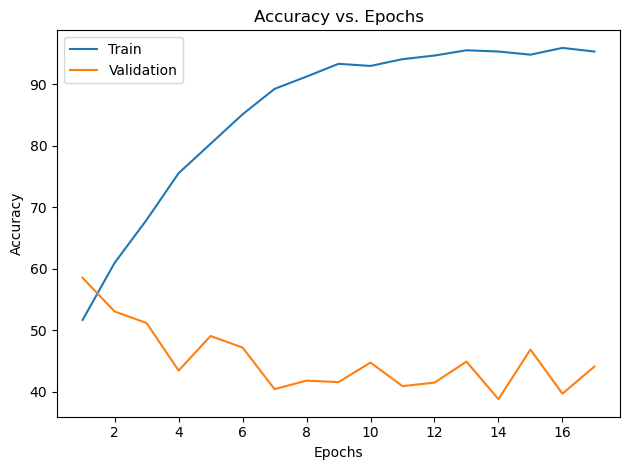

In [27]:
if mlp_params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )

/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1015: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1016: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


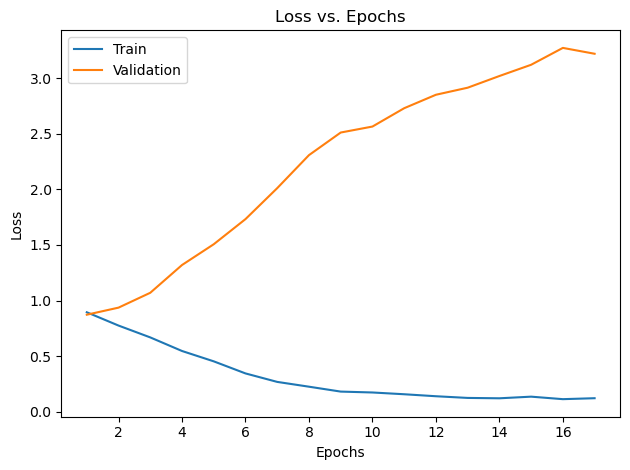

In [28]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

### Test Models on training data

In [29]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MLP_test_shuffle


In [30]:
stats_df = output_stats(
    y_pred_list,
    Y_train,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       149
           1       0.54      0.74      0.63      2672
           2       0.42      0.26      0.32      2084

    accuracy                           0.51      4905
   macro avg       0.32      0.33      0.31      4905
weighted avg       0.47      0.51      0.48      4905



/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [31]:
stats_df["group"] = "train"
stats_df["shuffled_data"] = mlp_params.SHUFFLE
stats_df
model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

### Test models on Validation data

In [32]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MLP_test_shuffle


In [33]:
stats_df = output_stats(
    y_pred_list,
    Y_val,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.60      0.77      0.67       669
           2       0.56      0.39      0.46       521

    accuracy                           0.59      1227
   macro avg       0.38      0.39      0.38      1227
weighted avg       0.56      0.59      0.56      1227



/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [34]:
stats_df["group"] = "validation"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_296492/1023299338.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


In [35]:
mlp_params.MODEL_NAME

'MLP_test'

### Testing on the test data

In [36]:
# create a dataframe to store the model confusion matrix
data_split_conf_mat_df_all = pd.DataFrame(
    columns=["True_Label", "Predicted_Label", "Count", "data_split", "Recall"]
)

In [37]:
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MLP_test_shuffle


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       187
           1       0.56      0.76      0.64      3341
           2       0.57      0.38      0.46      2983

    accuracy                           0.56      6511
   macro avg       0.38      0.38      0.37      6511
weighted avg       0.55      0.56      0.54      6511

Precision for class 0: 0.0
Recall for class 0: 0.0
Precision for class 1: 0.5583812472357363
Recall for class 1: 0.7557617479796468
Precision for class 2: 0.5694164989939637
Recall for class 2: 0.3794837412001341
3


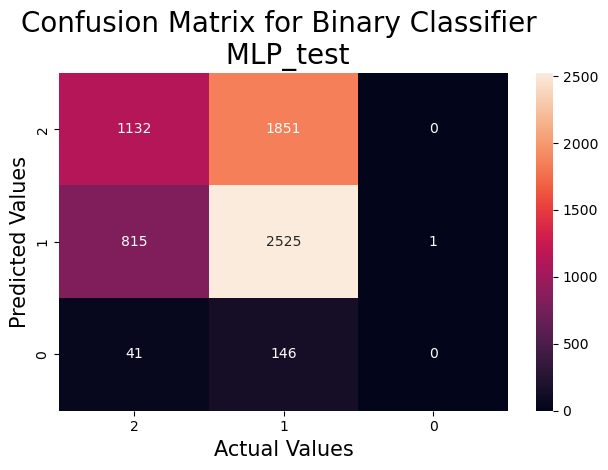

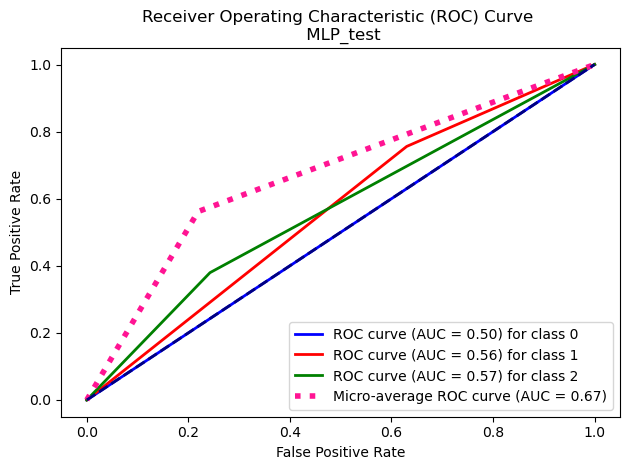

In [38]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_test,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [39]:
metadata_test

,Metadata_cell_type,Metadata_Well,Metadata_number_of_singlecells,Metadata_incubation inducer (h),Metadata_inhibitor,Metadata_inhibitor_concentration,Metadata_inhibitor_concentration_unit,Metadata_inducer1,Metadata_inducer1_concentration,Metadata_inducer1_concentration_unit,...,Metadata_inducer2_concentration_unit,Metadata_ImageNumber,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels
0,SH-SY5Y,C14,4260,6,DMSO,0.025,%,DMSO,0.100,%,...,None,200,*70117_20230210MM1_Gasdermin514_CP_BC430856,142,142,146,146,DMSO,0.100_%,healthy
2,SH-SY5Y,J15,4439,6,DMSO,0.025,%,DMSO,0.100,%,...,None,228,*70117_20230210MM1_Gasdermin514_CP_BC430856,279,279,293,293,DMSO,0.100_%,healthy
3,SH-SY5Y,B14,4281,6,DMSO,0.025,%,DMSO,0.100,%,...,None,21,*70117_20230210MM1_Gasdermin514_CP_BC430856,178,178,187,187,DMSO,0.100_%,healthy
9,SH-SY5Y,B15,4514,6,DMSO,0.025,%,DMSO,0.100,%,...,None,44,*70117_20230210MM1_Gasdermin514_CP_BC430856,195,195,204,204,DMSO,0.100_%,healthy
11,SH-SY5Y,I15,4720,6,DMSO,0.025,%,DMSO,0.100,%,...,None,49,*70117_20230210MM1_Gasdermin514_CP_BC430856,94,94,99,99,DMSO,0.100_%,healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18987,SH-SY5Y,O19,3881,6,Media_ctr,nan,None,media_ctr,0.0,µg_per_ml,...,None,1170,*70117_20230210MM1_Gasdermin514_CP_BC430856,83,83,91,91,media_ctr,0.0_µg_per_ml,healthy
18989,SH-SY5Y,O19,3881,6,Media_ctr,nan,None,media_ctr,0.0,µg_per_ml,...,None,1172,*70117_20230210MM1_Gasdermin514_CP_BC430856,58,58,65,65,media_ctr,0.0_µg_per_ml,healthy
18991,SH-SY5Y,O19,3881,6,Media_ctr,nan,None,media_ctr,0.0,µg_per_ml,...,None,1172,*70117_20230210MM1_Gasdermin514_CP_BC430856,42,42,48,48,media_ctr,0.0_µg_per_ml,healthy
18992,SH-SY5Y,O19,3881,6,Media_ctr,nan,None,media_ctr,0.0,µg_per_ml,...,None,1171,*70117_20230210MM1_Gasdermin514_CP_BC430856,111,111,113,113,media_ctr,0.0_µg_per_ml,healthy


In [40]:
# define a final dataframe to store the predictions
final_predictions_df = pd.DataFrame()

In [41]:
# merge the y_pred_list and Y_holdout into a dataframe
y_pred_df = pd.DataFrame(y_pred_list, columns=["y_pred"])
y_pred_df = pd.concat([y_pred_df, Y_test], axis=1)
y_pred_df = pd.concat([y_pred_df, X_test], axis=1)

In [42]:
# merge y_pred_df with metadata_holdout whiile keeping the index of metadata_holdout
metadata_test.reset_index(inplace=True)
y_pred_df = pd.concat([y_pred_df, metadata_test], axis=1)
# set the index to the index column
y_pred_df.set_index("index", inplace=True, drop=True)

In [43]:
# save the y_pred_df to a parquet file
# set path
y_pred_df_path = pathlib.Path(
    f"../../results/Multi_Class/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}/testing_single_cell_predictions.parquet"
)
# make path if it doesn't exist
y_pred_df_path.parent.mkdir(parents=True, exist_ok=True)
# save the dataframe
y_pred_df.to_parquet(y_pred_df_path)

In [44]:
y_pred_df["data_split"] = "test"

In [45]:
final_predictions_df = pd.concat([final_predictions_df, y_pred_df], axis=0)
final_predictions_df

,y_pred,new_labels,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,...,Metadata_ImageNumber,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels,data_split
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,-0.071914,-0.994398,0.218033,-0.263332,-1.228448,-0.479378,-0.181941,0.380014,...,200,*70117_20230210MM1_Gasdermin514_CP_BC430856,142,142,146,146,DMSO,0.100_%,healthy,test
2,1,1,-0.493362,-1.549338,-0.495264,0.259721,-0.863960,0.287565,-0.563368,0.276087,...,228,*70117_20230210MM1_Gasdermin514_CP_BC430856,279,279,293,293,DMSO,0.100_%,healthy,test
3,1,1,0.587367,0.751369,0.315198,-0.805371,1.994867,1.147881,1.715188,-0.320202,...,21,*70117_20230210MM1_Gasdermin514_CP_BC430856,178,178,187,187,DMSO,0.100_%,healthy,test
9,1,1,-0.699561,1.148534,0.878413,0.599515,2.700113,0.450582,1.649439,0.051196,...,44,*70117_20230210MM1_Gasdermin514_CP_BC430856,195,195,204,204,DMSO,0.100_%,healthy,test
11,1,1,-0.620468,0.445470,0.446017,0.460870,-1.024122,-1.149976,-1.120988,-0.095155,...,49,*70117_20230210MM1_Gasdermin514_CP_BC430856,94,94,99,99,DMSO,0.100_%,healthy,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18987,1,1,-0.484928,-2.566172,-0.105124,0.247224,0.075252,2.176762,0.865309,0.126333,...,1170,*70117_20230210MM1_Gasdermin514_CP_BC430856,83,83,91,91,media_ctr,0.0_µg_per_ml,healthy,test
18989,1,1,-0.844481,0.801228,0.855494,0.885702,0.008848,-0.642953,1.035061,0.333430,...,1172,*70117_20230210MM1_Gasdermin514_CP_BC430856,58,58,65,65,media_ctr,0.0_µg_per_ml,healthy,test
18991,1,1,1.157487,1.130687,-1.202669,-1.121328,0.665426,-0.822609,0.845544,-1.355398,...,1172,*70117_20230210MM1_Gasdermin514_CP_BC430856,42,42,48,48,media_ctr,0.0_µg_per_ml,healthy,test


In [46]:
# rename columns from the decoder dictionary
confusion_matrix_df.rename(
    columns={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)
confusion_matrix_df.rename(
    index={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)

In [47]:
confusion_matrix_df

,apoptosis,healthy,pyroptosis
apoptosis,0,146,41
healthy,1,2525,815
pyroptosis,0,1851,1132


In [48]:
confusion_matrices = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices = pd.melt(
    confusion_matrices,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices["data_split"] = "testing"
# sum of the columns of the confusion matrix gives the total number of samples per class
sum_of_columns = confusion_matrix_df.sum(axis=0)

In [49]:
confusion_matrices

,True_Label,Predicted_Label,Count,data_split
0,apoptosis,healthy,146,testing
1,healthy,healthy,2525,testing
2,pyroptosis,healthy,1851,testing
3,apoptosis,apoptosis,0,testing
4,healthy,apoptosis,1,testing
5,pyroptosis,apoptosis,0,testing
6,apoptosis,pyroptosis,41,testing
7,healthy,pyroptosis,815,testing
8,pyroptosis,pyroptosis,1132,testing


In [50]:
# normalize confusion matrix
# get the sum of each column to normalize the confusion matrix by the total number of samples per class

# divide the apotosis column by the sum of the apotosis column
confusion_matrix_df["apoptosis"] = confusion_matrix_df["apoptosis"] / sum_of_columns[0]
# divide the healthy column by the sum of the healthy column
confusion_matrix_df["healthy"] = confusion_matrix_df["healthy"] / sum_of_columns[1]
# divide the pyroptosis column by the sum of the pyroptosis column
confusion_matrix_df["pyroptosis"] = (
    confusion_matrix_df["pyroptosis"] / sum_of_columns[2]
)

In [51]:
confusion_matrix_df

,apoptosis,healthy,pyroptosis
apoptosis,0.0,0.032287,0.020624
healthy,1.0,0.558381,0.409960
pyroptosis,0.0,0.409332,0.569416


In [52]:
confusion_matrices_recall = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices_recall = pd.melt(
    confusion_matrices_recall,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices_recall.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices_recall["data_split"] = "testing"
confusion_matrices_recall.rename(columns={"Count": "Recall"}, inplace=True)
data_split_conf_mat_df = pd.merge(
    confusion_matrices,
    confusion_matrices_recall,
    on=["True_Label", "Predicted_Label", "data_split"],
)
data_split_conf_mat_df["shuffled_data"] = mlp_params.SHUFFLE
data_split_conf_mat_df_all = pd.concat(
    [data_split_conf_mat_df_all, data_split_conf_mat_df], axis=0
)

In [53]:
data_split_conf_mat_df_all

,True_Label,Predicted_Label,Count,data_split,Recall,shuffled_data
0,apoptosis,healthy,146,testing,0.032287,True
1,healthy,healthy,2525,testing,0.558381,True
2,pyroptosis,healthy,1851,testing,0.409332,True
3,apoptosis,apoptosis,0,testing,0.000000,True
4,healthy,apoptosis,1,testing,1.000000,True
5,pyroptosis,apoptosis,0,testing,0.000000,True
6,apoptosis,pyroptosis,41,testing,0.020624,True
7,healthy,pyroptosis,815,testing,0.409960,True
8,pyroptosis,pyroptosis,1132,testing,0.569416,True


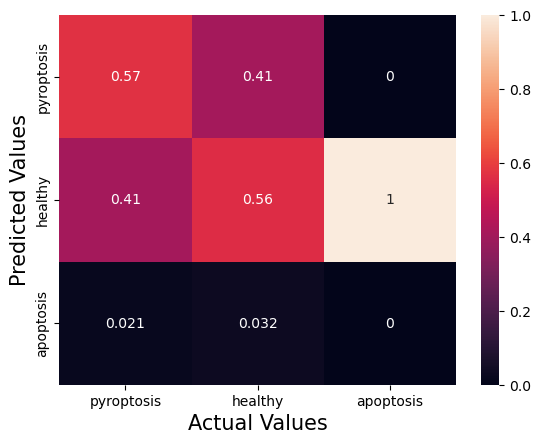

In [54]:
ax = sns.heatmap(confusion_matrix_df, annot=True)
ax.invert_xaxis()
ax.invert_yaxis()
plt.xlabel("Actual Values", size=15)
plt.ylabel("Predicted Values", size=15)
plt.show()

In [55]:
stats_df = output_stats(
    y_pred_list,
    Y_test,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       187
           1       0.56      0.76      0.64      3341
           2       0.57      0.38      0.46      2983

    accuracy                           0.56      6511
   macro avg       0.38      0.38      0.37      6511
weighted avg       0.55      0.56      0.54      6511



/tmp/ipykernel_296492/832989993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [56]:
stats_df["group"] = "test"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_296492/3610522228.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


## Test the treatment holdout data on the model

MLP_test_shuffle


/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       373
           1       0.24      0.69      0.36       354
           2       0.52      0.31      0.39       739

    accuracy                           0.33      1466
   macro avg       0.25      0.34      0.25      1466
weighted avg       0.32      0.33      0.28      1466

Precision for class 0: 0.0
Recall for class 0: 0.0
Precision for class 1: 0.24066797642436152
Recall for class 1: 0.692090395480226
Precision for class 2: 0.5178571428571429
Recall for class 2: 0.31393775372124494
3


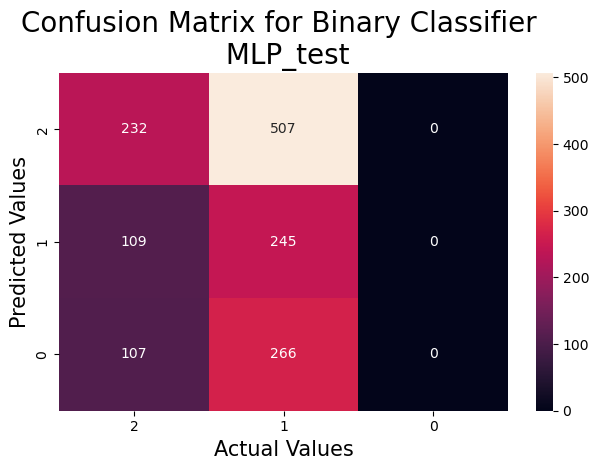

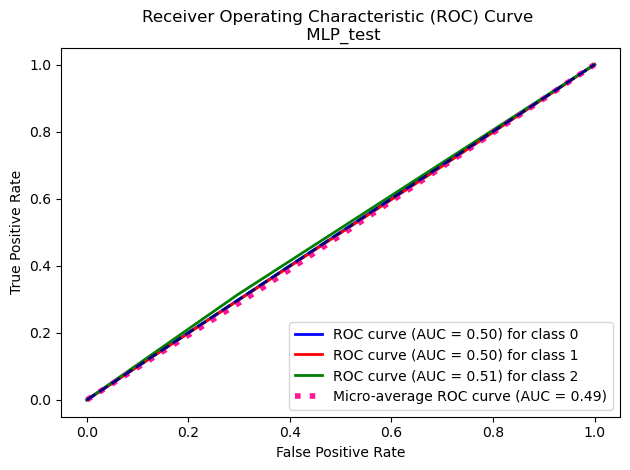

In [57]:
treatment_holdout_data = Dataset_formatter(
    torch.FloatTensor(X_treatment_holdout.values),
    torch.FloatTensor(Y_treatment_holdout.values),
)

# convert data class into a dataloader to be compatible with pytorch
treatment_holdout_loader = torch.utils.data.DataLoader(
    dataset=treatment_holdout_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        treatment_holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        treatment_holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_treatment_holdout):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_treatment_holdout,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_treatment_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_treatment_holdout,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_treatment_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [58]:
final_predictions_df

,y_pred,new_labels,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,...,Metadata_ImageNumber,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels,data_split
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,-0.071914,-0.994398,0.218033,-0.263332,-1.228448,-0.479378,-0.181941,0.380014,...,200,*70117_20230210MM1_Gasdermin514_CP_BC430856,142,142,146,146,DMSO,0.100_%,healthy,test
2,1,1,-0.493362,-1.549338,-0.495264,0.259721,-0.863960,0.287565,-0.563368,0.276087,...,228,*70117_20230210MM1_Gasdermin514_CP_BC430856,279,279,293,293,DMSO,0.100_%,healthy,test
3,1,1,0.587367,0.751369,0.315198,-0.805371,1.994867,1.147881,1.715188,-0.320202,...,21,*70117_20230210MM1_Gasdermin514_CP_BC430856,178,178,187,187,DMSO,0.100_%,healthy,test
9,1,1,-0.699561,1.148534,0.878413,0.599515,2.700113,0.450582,1.649439,0.051196,...,44,*70117_20230210MM1_Gasdermin514_CP_BC430856,195,195,204,204,DMSO,0.100_%,healthy,test
11,1,1,-0.620468,0.445470,0.446017,0.460870,-1.024122,-1.149976,-1.120988,-0.095155,...,49,*70117_20230210MM1_Gasdermin514_CP_BC430856,94,94,99,99,DMSO,0.100_%,healthy,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18987,1,1,-0.484928,-2.566172,-0.105124,0.247224,0.075252,2.176762,0.865309,0.126333,...,1170,*70117_20230210MM1_Gasdermin514_CP_BC430856,83,83,91,91,media_ctr,0.0_µg_per_ml,healthy,test
18989,1,1,-0.844481,0.801228,0.855494,0.885702,0.008848,-0.642953,1.035061,0.333430,...,1172,*70117_20230210MM1_Gasdermin514_CP_BC430856,58,58,65,65,media_ctr,0.0_µg_per_ml,healthy,test
18991,1,1,1.157487,1.130687,-1.202669,-1.121328,0.665426,-0.822609,0.845544,-1.355398,...,1172,*70117_20230210MM1_Gasdermin514_CP_BC430856,42,42,48,48,media_ctr,0.0_µg_per_ml,healthy,test


In [59]:
# merge the y_pred_list and Y_holdout into a dataframe
y_pred_df = pd.DataFrame(y_pred_list, columns=["y_pred"])
y_pred_df = pd.concat([y_pred_df, Y_treatment_holdout], axis=1)
y_pred_df = pd.concat([y_pred_df, X_treatment_holdout], axis=1)

In [60]:
# merge y_pred_df with metadata_holdout whiile keeping the index of metadata_holdout
metadata_treatment_holdout.reset_index(inplace=True)
y_pred_df = pd.concat([y_pred_df, metadata_treatment_holdout], axis=1)
# set the index to the index column
y_pred_df.set_index("index", inplace=True, drop=True)

In [61]:
y_pred_df["data_split"] = "treatment_holdout"

In [62]:
final_predictions_df = pd.concat([final_predictions_df, y_pred_df], axis=0)
final_predictions_df

,y_pred,new_labels,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,...,Metadata_ImageNumber,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels,data_split
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,-0.071914,-0.994398,0.218033,-0.263332,-1.228448,-0.479378,-0.181941,0.380014,...,200,*70117_20230210MM1_Gasdermin514_CP_BC430856,142,142,146,146,DMSO,0.100_%,healthy,test
2,1,1,-0.493362,-1.549338,-0.495264,0.259721,-0.863960,0.287565,-0.563368,0.276087,...,228,*70117_20230210MM1_Gasdermin514_CP_BC430856,279,279,293,293,DMSO,0.100_%,healthy,test
3,1,1,0.587367,0.751369,0.315198,-0.805371,1.994867,1.147881,1.715188,-0.320202,...,21,*70117_20230210MM1_Gasdermin514_CP_BC430856,178,178,187,187,DMSO,0.100_%,healthy,test
9,1,1,-0.699561,1.148534,0.878413,0.599515,2.700113,0.450582,1.649439,0.051196,...,44,*70117_20230210MM1_Gasdermin514_CP_BC430856,195,195,204,204,DMSO,0.100_%,healthy,test
11,1,1,-0.620468,0.445470,0.446017,0.460870,-1.024122,-1.149976,-1.120988,-0.095155,...,49,*70117_20230210MM1_Gasdermin514_CP_BC430856,94,94,99,99,DMSO,0.100_%,healthy,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15993,1,0,-0.679867,0.136815,0.718196,0.563932,-0.919936,-0.777483,1.474472,0.840716,...,409,*70117_20230210MM1_Gasdermin514_CP_BC430856,69,69,75,75,Thapsigargin,1.000_µM,apoptosis,treatment_holdout
15994,1,0,-1.020244,-0.336801,1.380189,1.302621,-0.964500,-0.487634,-1.476647,0.596985,...,400,*70117_20230210MM1_Gasdermin514_CP_BC430856,99,99,103,103,Thapsigargin,1.000_µM,apoptosis,treatment_holdout
15995,1,0,-0.683736,0.764673,0.131842,0.570865,-0.662328,-1.158813,0.733168,0.114775,...,412,*70117_20230210MM1_Gasdermin514_CP_BC430856,64,64,71,71,Thapsigargin,1.000_µM,apoptosis,treatment_holdout


In [63]:
# rename columns from the decoder dictionary
confusion_matrix_df.rename(
    columns={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)
# rename index from the decoder dictionary
confusion_matrix_df.rename(
    index={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)

In [64]:
confusion_matrices = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices = pd.melt(
    confusion_matrices,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices["data_split"] = "treatment_holdout"
# sum of the columns of the confusion matrix gives the total number of samples per class
sum_of_columns = confusion_matrix_df.sum(axis=0)

In [65]:
confusion_matrices

,True_Label,Predicted_Label,Count,data_split
0,apoptosis,healthy,266,treatment_holdout
1,healthy,healthy,245,treatment_holdout
2,pyroptosis,healthy,507,treatment_holdout
3,apoptosis,apoptosis,0,treatment_holdout
4,healthy,apoptosis,0,treatment_holdout
5,pyroptosis,apoptosis,0,treatment_holdout
6,apoptosis,pyroptosis,107,treatment_holdout
7,healthy,pyroptosis,109,treatment_holdout
8,pyroptosis,pyroptosis,232,treatment_holdout


In [66]:
# normalize confusion matrix
# get the sum of each column to normalize the confusion matrix by the total number of samples per class

# divide the apotosis column by the sum of the apotosis column
confusion_matrix_df["apoptosis"] = confusion_matrix_df["apoptosis"] / sum_of_columns[0]
# divide the healthy column by the sum of the healthy column
confusion_matrix_df["healthy"] = confusion_matrix_df["healthy"] / sum_of_columns[1]
# divide the pyroptosis column by the sum of the pyroptosis column
confusion_matrix_df["pyroptosis"] = (
    confusion_matrix_df["pyroptosis"] / sum_of_columns[2]
)

In [67]:
# change the order of the columns
confusion_matrix_df = confusion_matrix_df[["healthy", "apoptosis", "pyroptosis"]]
# change the order of the index
confusion_matrix_df = confusion_matrix_df.reindex(
    index=["healthy", "apoptosis", "pyroptosis"]
)

In [68]:
confusion_matrices_recall = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices_recall = pd.melt(
    confusion_matrices_recall,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices_recall.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices_recall["data_split"] = "treatment_holdout"
confusion_matrices_recall.rename(columns={"Count": "Recall"}, inplace=True)
data_split_conf_mat_df = pd.merge(
    confusion_matrices,
    confusion_matrices_recall,
    on=["True_Label", "Predicted_Label", "data_split"],
)
data_split_conf_mat_df["shuffled_data"] = mlp_params.SHUFFLE
data_split_conf_mat_df_all = pd.concat(
    [data_split_conf_mat_df_all, data_split_conf_mat_df], axis=0
)

/tmp/ipykernel_296492/3256508403.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data_split_conf_mat_df_all = pd.concat(


In [69]:
data_split_conf_mat_df

,True_Label,Predicted_Label,Count,data_split,Recall,shuffled_data
0,apoptosis,healthy,266,treatment_holdout,0.261297,True
1,healthy,healthy,245,treatment_holdout,0.240668,True
2,pyroptosis,healthy,507,treatment_holdout,0.498035,True
3,apoptosis,apoptosis,0,treatment_holdout,NaN,True
4,healthy,apoptosis,0,treatment_holdout,NaN,True
5,pyroptosis,apoptosis,0,treatment_holdout,NaN,True
6,apoptosis,pyroptosis,107,treatment_holdout,0.238839,True
7,healthy,pyroptosis,109,treatment_holdout,0.243304,True
8,pyroptosis,pyroptosis,232,treatment_holdout,0.517857,True


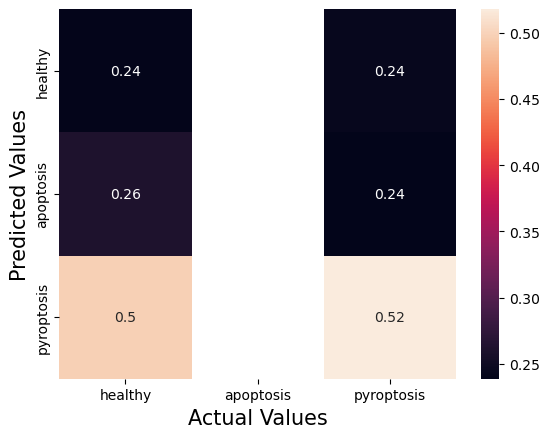

In [70]:
ax = sns.heatmap(confusion_matrix_df, annot=True)

plt.xlabel("Actual Values", size=15)
plt.ylabel("Predicted Values", size=15)
plt.show()

In [71]:
stats_df = output_stats(
    y_pred_list,
    Y_treatment_holdout,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       373
           1       0.24      0.69      0.36       354
           2       0.52      0.31      0.39       739

    accuracy                           0.33      1466
   macro avg       0.25      0.34      0.25      1466
weighted avg       0.32      0.33      0.28      1466



/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [72]:
stats_df["group"] = "treatment_holdout"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)
model_stats_df

/tmp/ipykernel_296492/819937216.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


,label,metric,value,group,shuffled_data
0,apoptosis,precision,0.000000,train,True
1,healthy,precision,0.542881,train,True
2,pyroptosis,precision,0.419890,train,True
3,accuracy,accuracy,0.511111,train,True
4,macro avg,precision,0.320923,train,True
...,...,...,...,...,...
19,healthy,support,354.000000,treatment_holdout,True
20,pyroptosis,support,739.000000,treatment_holdout,True
21,accuracy,accuracy,0.325375,treatment_holdout,True
22,macro avg,support,1466.000000,treatment_holdout,True


## Test the hold out wells

MLP_test_shuffle
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       254
           1       0.50      0.70      0.58      2464
           2       0.45      0.31      0.36      2173

    accuracy                           0.49      4891
   macro avg       0.65      0.34      0.32      4891
weighted avg       0.51      0.49      0.46      4891

Precision for class 0: 1.0
Recall for class 0: 0.003937007874015748
Precision for class 1: 0.5041152263374485
Recall for class 1: 0.6960227272727273
Precision for class 2: 0.448252688172043
Recall for class 2: 0.3069489185457892
3


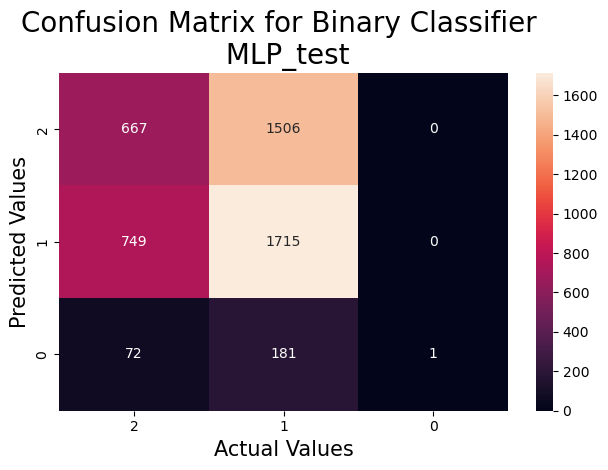

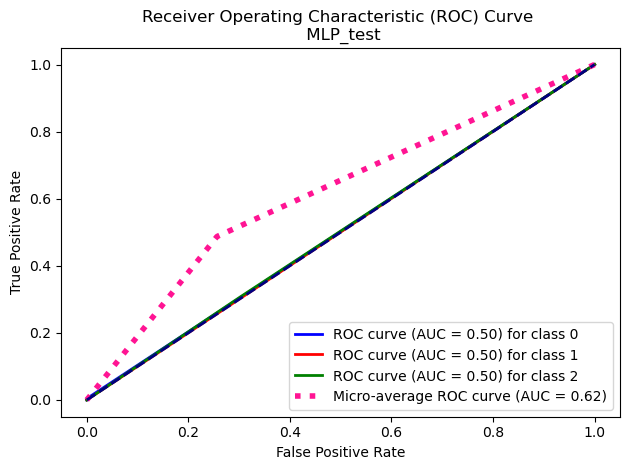

In [73]:
holdout_data = Dataset_formatter(
    torch.FloatTensor(X_holdout.values), torch.FloatTensor(Y_holdout.values)
)

# convert data class into a dataloader to be compatible with pytorch
holdout_loader = torch.utils.data.DataLoader(
    dataset=holdout_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_holdout):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_holdout,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_holdout,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [74]:
# merge the y_pred_list and Y_holdout into a dataframe
y_pred_df = pd.DataFrame(y_pred_list, columns=["y_pred"])
y_pred_df = pd.concat([y_pred_df, Y_holdout], axis=1)
y_pred_df = pd.concat([y_pred_df, X_holdout], axis=1)

In [75]:
y_pred_df

,y_pred,new_labels,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,...,Nuclei_Texture_InverseDifferenceMoment_CorrER_3_01_256,Nuclei_Texture_InverseDifferenceMoment_CorrER_3_02_256,Nuclei_Texture_InverseDifferenceMoment_CorrER_3_03_256,Nuclei_Texture_InverseDifferenceMoment_CorrMito_3_00_256,Nuclei_Texture_InverseDifferenceMoment_CorrPM_3_00_256,Nuclei_Texture_InverseDifferenceMoment_CorrPM_3_02_256,Nuclei_Texture_SumEntropy_CorrPM_3_01_256,Nuclei_Texture_SumVariance_CorrGasdermin_3_01_256,Nuclei_Texture_SumVariance_CorrMito_3_03_256,Nuclei_Texture_SumVariance_CorrPM_3_03_256
0,1,1,-0.349032,-0.088414,0.347856,0.058683,0.358109,0.884612,0.588685,0.028787,...,0.817170,0.899320,0.959008,-0.028463,0.423450,0.535105,-0.638750,-0.068286,-0.115314,-0.050324
1,1,1,1.163328,1.251694,-0.674719,-1.124071,0.403936,-1.309822,0.279892,-1.492310,...,1.351611,1.029169,0.803277,1.675957,0.658865,0.660558,-1.092866,-0.070941,-0.133799,-0.065798
2,1,1,-0.699575,0.345115,0.669142,0.599540,0.763779,0.771747,0.210303,-0.106997,...,-1.689281,-1.305742,-0.840267,-1.238011,-2.392110,-1.614757,1.475035,-0.033002,0.007067,0.140957
3,1,1,0.227242,-0.458779,0.104030,-0.540459,-0.427128,0.269063,1.571794,0.415826,...,1.387593,0.830547,0.660015,1.586437,0.487820,0.307017,-0.862775,-0.069448,-0.129456,-0.058372
4,2,1,-0.473491,-0.559830,0.488546,0.230434,-0.248651,0.573473,0.851541,-0.127455,...,-1.424683,-1.027434,-1.192015,-2.485611,-1.574269,-1.120052,0.900842,0.015297,0.180444,0.013963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4886,1,1,1.148277,-0.993415,-0.709547,-1.116984,-0.219376,0.918713,1.488822,-0.202056,...,-0.545009,-0.639460,-0.369530,0.338093,0.279541,-0.651693,0.411598,-0.052139,-0.101634,0.011673
4887,2,1,-0.350793,-2.470111,0.648324,0.060982,0.477332,2.788741,-1.190072,1.356729,...,0.379767,-0.194702,-0.427253,0.537869,0.972507,0.731933,-1.009845,-0.060960,-0.100310,-0.061201
4888,1,1,0.664873,1.237834,-1.110773,-0.854777,0.059384,-1.473791,-1.131043,-1.453136,...,-0.414456,-0.142971,0.780662,0.101505,1.080007,1.022187,-0.756479,-0.057360,-0.055970,-0.058054
4889,1,1,0.686581,-2.047191,0.175406,-0.868199,-0.677090,0.773183,-1.310839,0.944153,...,0.377701,0.478666,0.857179,1.298499,0.990752,0.933835,-0.307455,-0.057316,-0.108546,-0.038802


In [76]:
# merge y_pred_df with metadata_holdout whiile keeping the index of metadata_holdout
metadata_holdout.reset_index(inplace=True)
y_pred_df = pd.concat([y_pred_df, metadata_holdout], axis=1)
# set the index to the index column
y_pred_df.set_index("index", inplace=True, drop=True)

In [77]:
y_pred_df["data_split"] = "holdout"

In [78]:
final_predictions_df = pd.concat([final_predictions_df, y_pred_df], axis=0)
final_predictions_df

,y_pred,new_labels,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,...,Metadata_ImageNumber,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels,data_split
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,-0.071914,-0.994398,0.218033,-0.263332,-1.228448,-0.479378,-0.181941,0.380014,...,200,*70117_20230210MM1_Gasdermin514_CP_BC430856,142,142,146,146,DMSO,0.100_%,healthy,test
2,1,1,-0.493362,-1.549338,-0.495264,0.259721,-0.863960,0.287565,-0.563368,0.276087,...,228,*70117_20230210MM1_Gasdermin514_CP_BC430856,279,279,293,293,DMSO,0.100_%,healthy,test
3,1,1,0.587367,0.751369,0.315198,-0.805371,1.994867,1.147881,1.715188,-0.320202,...,21,*70117_20230210MM1_Gasdermin514_CP_BC430856,178,178,187,187,DMSO,0.100_%,healthy,test
9,1,1,-0.699561,1.148534,0.878413,0.599515,2.700113,0.450582,1.649439,0.051196,...,44,*70117_20230210MM1_Gasdermin514_CP_BC430856,195,195,204,204,DMSO,0.100_%,healthy,test
11,1,1,-0.620468,0.445470,0.446017,0.460870,-1.024122,-1.149976,-1.120988,-0.095155,...,49,*70117_20230210MM1_Gasdermin514_CP_BC430856,94,94,99,99,DMSO,0.100_%,healthy,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18990,1,1,1.148277,-0.993415,-0.709547,-1.116984,-0.219376,0.918713,1.488822,-0.202056,...,1167,*70117_20230210MM1_Gasdermin514_CP_BC430856,148,148,160,160,media_ctr,0.0_µg_per_ml,healthy,holdout
18993,2,1,-0.350793,-2.470111,0.648324,0.060982,0.477332,2.788741,-1.190072,1.356729,...,1154,*70117_20230210MM1_Gasdermin514_CP_BC430856,6,6,9,9,media_ctr,0.0_µg_per_ml,healthy,holdout
18997,1,1,0.664873,1.237834,-1.110773,-0.854777,0.059384,-1.473791,-1.131043,-1.453136,...,1152,*70117_20230210MM1_Gasdermin514_CP_BC430856,82,82,90,90,media_ctr,0.0_µg_per_ml,healthy,holdout


In [79]:
# # save the y_pred_df to a parquet file
# # set path
# y_pred_df_path = pathlib.Path(
#     f"../../results/Multi_Class/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}/holdout_single_cell_predictions.parquet"
# )
# # make path if it doesn't exist
# y_pred_df_path.parent.mkdir(parents=True, exist_ok=True)
# # save the dataframe
# y_pred_df.to_parquet(y_pred_df_path)

In [80]:
# rename columns from the decoder dictionary
confusion_matrix_df.rename(
    columns={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)
# rename index from the decoder dictionary
confusion_matrix_df.rename(
    index={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)

In [81]:
confusion_matrices = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices = pd.melt(
    confusion_matrices,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices["data_split"] = "holdout"
# sum of the columns of the confusion matrix gives the total number of samples per class
sum_of_columns = confusion_matrix_df.sum(axis=0)

In [82]:
confusion_matrices

,True_Label,Predicted_Label,Count,data_split
0,apoptosis,healthy,181,holdout
1,healthy,healthy,1715,holdout
2,pyroptosis,healthy,1506,holdout
3,apoptosis,apoptosis,1,holdout
4,healthy,apoptosis,0,holdout
5,pyroptosis,apoptosis,0,holdout
6,apoptosis,pyroptosis,72,holdout
7,healthy,pyroptosis,749,holdout
8,pyroptosis,pyroptosis,667,holdout


In [83]:
# normalize confusion matrix
# get the sum of each column to normalize the confusion matrix by the total number of samples per class

# divide the apotosis column by the sum of the apotosis column
confusion_matrix_df["apoptosis"] = confusion_matrix_df["apoptosis"] / sum_of_columns[0]
# divide the healthy column by the sum of the healthy column
confusion_matrix_df["healthy"] = confusion_matrix_df["healthy"] / sum_of_columns[1]
# divide the pyroptosis column by the sum of the pyroptosis column
confusion_matrix_df["pyroptosis"] = (
    confusion_matrix_df["pyroptosis"] / sum_of_columns[2]
)

In [84]:
# change the order of the columns
confusion_matrix_df = confusion_matrix_df[["healthy", "apoptosis", "pyroptosis"]]
# change the order of the index
confusion_matrix_df = confusion_matrix_df.reindex(
    index=["healthy", "apoptosis", "pyroptosis"]
)

In [85]:
confusion_matrices_recall = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices_recall = pd.melt(
    confusion_matrices_recall,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices_recall.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices_recall["data_split"] = "holdout"
confusion_matrices_recall.rename(columns={"Count": "Recall"}, inplace=True)
data_split_conf_mat_df = pd.merge(
    confusion_matrices,
    confusion_matrices_recall,
    on=["True_Label", "Predicted_Label", "data_split"],
)
data_split_conf_mat_df["shuffled_data"] = mlp_params.SHUFFLE
data_split_conf_mat_df_all = pd.concat(
    [data_split_conf_mat_df_all, data_split_conf_mat_df], axis=0
)

/tmp/ipykernel_296492/2372900873.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data_split_conf_mat_df_all = pd.concat(


In [86]:
data_split_conf_mat_df

,True_Label,Predicted_Label,Count,data_split,Recall,shuffled_data
0,apoptosis,healthy,181,holdout,0.053204,True
1,healthy,healthy,1715,holdout,0.504115,True
2,pyroptosis,healthy,1506,holdout,0.442681,True
3,apoptosis,apoptosis,1,holdout,1.000000,True
4,healthy,apoptosis,0,holdout,0.000000,True
5,pyroptosis,apoptosis,0,holdout,0.000000,True
6,apoptosis,pyroptosis,72,holdout,0.048387,True
7,healthy,pyroptosis,749,holdout,0.503360,True
8,pyroptosis,pyroptosis,667,holdout,0.448253,True


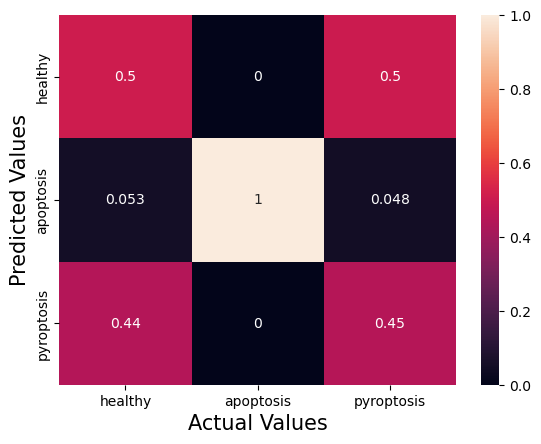

In [87]:
ax = sns.heatmap(confusion_matrix_df, annot=True)

plt.xlabel("Actual Values", size=15)
plt.ylabel("Predicted Values", size=15)
plt.show()

In [88]:
stats_df = output_stats(
    y_pred_list,
    Y_holdout,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       254
           1       0.50      0.70      0.58      2464
           2       0.45      0.31      0.36      2173

    accuracy                           0.49      4891
   macro avg       0.65      0.34      0.32      4891
weighted avg       0.51      0.49      0.46      4891



/tmp/ipykernel_296492/3730111117.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [89]:
stats_df["group"] = "holdout"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)
model_stats_df

/tmp/ipykernel_296492/1582550840.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


,label,metric,value,group,shuffled_data
0,apoptosis,precision,0.000000,train,True
1,healthy,precision,0.542881,train,True
2,pyroptosis,precision,0.419890,train,True
3,accuracy,accuracy,0.511111,train,True
4,macro avg,precision,0.320923,train,True
...,...,...,...,...,...
19,healthy,support,2464.000000,holdout,True
20,pyroptosis,support,2173.000000,holdout,True
21,accuracy,accuracy,0.487221,holdout,True
22,macro avg,support,4891.000000,holdout,True


In [90]:
# set path for the model confusion matrices
predictions_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
predictions_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
matrix_file = pathlib.Path(f"{predictions_path}/single_cell_predictions.parquet")
if matrix_file.exists():
    predictions_df_tmp = pd.read_parquet(matrix_file)
    if len(predictions_df_tmp["data_split"].unique()) > 1:
        pass
    elif predictions_df_tmp["data_split"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([predictions_df_tmp, final_predictions_df], axis=0)
        metrics_df.to_parquet(matrix_file, index=False)
else:
    final_predictions_df.to_parquet(matrix_file, index=False)

In [91]:
# set path for the model confusion matrices
matrix_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
matrix_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
matrix_file = pathlib.Path(f"{matrix_path}/confusion_matrices.csv")
if matrix_file.exists():
    metrics_df = pd.read_csv(matrix_file)
    if len(metrics_df["shuffled_data"].unique()) > 1:
        pass
    elif metrics_df["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, data_split_conf_mat_df_all], axis=0)
        metrics_df.to_csv(matrix_file, index=False)
else:
    data_split_conf_mat_df_all.to_csv(matrix_file, index=False)

In [92]:
# set path for the model training metrics
metrics_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
metrics_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
metrics_file = pathlib.Path(f"{metrics_path}/training_metrics.csv")
if metrics_file.exists():
    metrics_df = pd.read_csv(metrics_file)
    if len(metrics_df["shuffled_data"].unique()) > 1:
        pass
    elif metrics_df["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, model_stats_df], axis=0)
        metrics_df.to_csv(metrics_file, index=False)
else:
    model_stats_df.to_csv(metrics_file, index=False)